## FITS Image Registration

AUTHOR : Mike Tyszka
DATES  : 2018-11-21 JMT From scratch

In [30]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from skimage import img_as_float64
from skimage.transform import EuclideanTransform, AffineTransform, warp
import SimpleITK as sitk

In [32]:
# Load noisy M16 image
fname = 'M16_Halpha.fit'
with fits.open(fname) as hdu_list:
    img = img_as_float64(hdu_list[0].data)
    
ny, nx = img.shape

In [33]:
# Create small rigid body (Euclidean) transform
rot = 5.0 * np.pi/180.0
trans = 10.0, 30.0
T = EuclideanTransform(rotation=rot, translation=trans)

# Transform the original image
img_tx = warp(img, T, order=3)

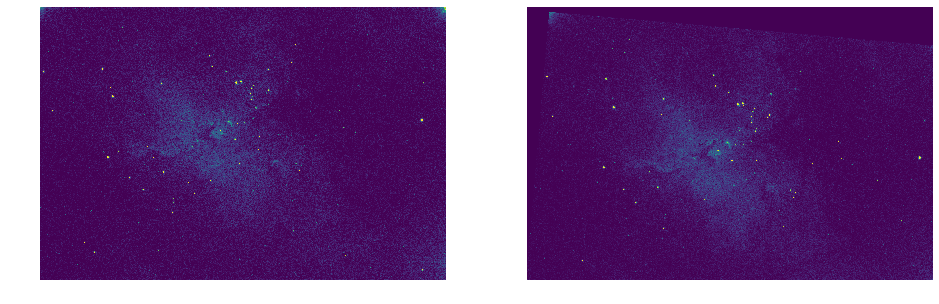

In [34]:
# Display original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(16,16))

ax[0].imshow(img, origin='lower')
ax[0].axis('off')
ax[1].imshow(img_tx, origin='lower')
ax[1].axis('off')

plt.show()

In [50]:
# Convert images to SimpleITK objects
fixed = sitk.GetImageFromArray(img)
moving = sitk.GetImageFromArray(img_tx)

In [52]:
# Initial transform estimate
initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                      moving, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

In [53]:
# Setup ITK registration
R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200 )
R.SetInitialTransform(initial_transform)
R.SetInterpolator(sitk.sitkLinear)

In [55]:
# Run ITK registration
outTx = R.Execute(fixed, moving)

print(outTx)

itk::simple::Transform
 Euler2DTransform (0x7ff551c7a640)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 5240
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     -0.176567 0.984289 
     -0.984289 -0.176567 
   Offset: [797.478, 2746.24]
   Center: [1547.5, 1039.5]
   Translation: [-0.0917254, 0.0156188]
   Inverse: 
     -0.176567 -0.984289 
     0.984289 -0.176567 
   Singular: 0
   Angle       = -1.74829



In [58]:
# Resample moving image
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

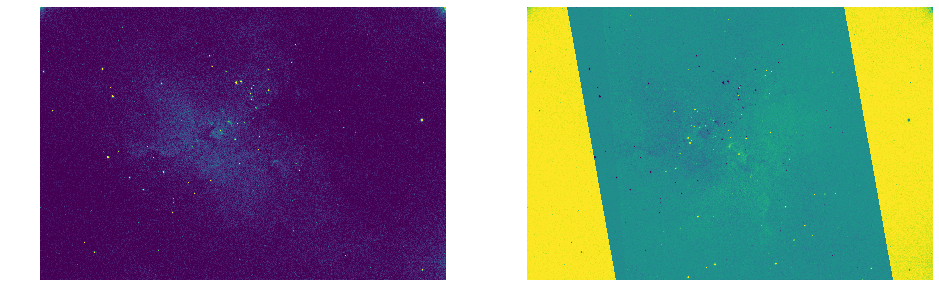

In [64]:
# Display registration errors
img_err = sitk.GetArrayFromImage(out - fixed)

fig, ax = plt.subplots(1, 2, figsize=(16,16))

ax[0].imshow(img, origin='lower')
ax[0].axis('off')
ax[1].imshow(img_err, origin='lower')
ax[1].axis('off')

plt.show()